In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

In [2]:
patients = pd.read_csv('PATIENTS.csv')
icu_stays = pd.read_csv('ICUSTAYS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
labevents = pd.read_csv("LABEVENTS.csv") 
diagnoses = pd.read_csv("DIAGNOSES_ICD.csv")

In [3]:
patients.head(2)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1


In [4]:
print(icu_stays.shape)
icu_stays.head(2)

(136, 12)


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325
1,12747,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507


In [5]:
print(admissions.shape)
admissions.head(2)

(129, 19)


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1


In [6]:
print(labevents.shape)
labevents.head(2)

(76074, 9)


,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag
0,6244563,10006,NaN,50868,2164-09-24 20:21:00,19,19.0,mEq/L,NaN
1,6244564,10006,NaN,50882,2164-09-24 20:21:00,27,27.0,mEq/L,NaN


In [7]:
print(diagnoses.shape)
diagnoses.head(2)

(1761, 5)


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662


---

## Data processing & cleaning

#### Target variable - death during ICU - who died between `in time` and `out time` of ICU

In [8]:
df = icu_stays.merge(admissions, on="hadm_id", how="left")

df["intime"] = pd.to_datetime(df["intime"])
df["outtime"] = pd.to_datetime(df["outtime"])
df["deathtime"] = pd.to_datetime(df["deathtime"])

df["died_during_icu"] = (df["deathtime"].notna()) & (df["deathtime"] >= df["intime"]) & (df["deathtime"] <= df["outtime"])
df["died_during_icu"] = df["died_during_icu"].astype(int)

#### Extracting the age of every patient who died during ICU
To keep format - every big and unreasonable value (120+) converted to the maximum age (92)

In [9]:
patients["dob"] = pd.to_datetime(patients["dob"], errors="coerce").dt.date
patients["dod"] = pd.to_datetime(patients["dod"], errors="coerce").dt.date
ages = []
for i in (patients["dod"] - patients["dob"])/365:
    if i.days > 120: # although the command is `days` - the representation is years
        i = 100
        ages.append(i)
    else:
        ages.append(i.days)
patients["age"] = ages

In [10]:
df = df.rename(columns={'subject_id_x':'subject_id'})
df = df.merge(patients, on = 'subject_id', how= 'left') # Merging with patients information for depographic features

In [11]:
# Create 'age_group' column
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

In [12]:

df = df[['subject_id','hadm_id', 'icustay_id','gender','age','age_group', 'ethnicity','died_during_icu']] # Keeping only relevant features

#### Potassium information extraction from `Lab Events` table:
Taking 5 estimators:
  - first and last potassium measures.
  - mean and median potassium values.
  - max potassium value.

In [13]:
# Extract Potassium measurements (itemid = 50971)
potassium = labevents[labevents['itemid'] == 50971][['hadm_id', 'valuenum']]

estimators = ["first", "mean", "median", "last", "max"]

# Group by hadm_id and calculate statistics
potassium_rates = potassium.groupby("hadm_id").agg({"valuenum": estimators}).reset_index()
potassium_rates = pd.concat([potassium_rates['hadm_id'], potassium_rates['valuenum']], axis=1)
potassium_rates.rename(columns={col: col + '_potassium' for col in estimators}, inplace=True)

potassium_rates


,hadm_id,first_potassium,mean_potassium,median_potassium,last_potassium,max_potassium
0,100375.0,3.8,3.880000,3.80,3.8,4.5
1,100969.0,4.4,3.925000,4.15,4.2,4.4
2,101361.0,3.1,4.255556,4.35,4.9,4.9
3,102203.0,4.2,3.662500,3.75,3.7,4.2
4,103379.0,3.4,3.493333,3.50,3.8,4.0
...,...,...,...,...,...,...
124,198330.0,3.6,3.728571,3.80,3.5,4.1
125,198480.0,4.0,4.109091,3.80,5.8,5.8
126,198503.0,4.2,4.125000,3.90,5.7,5.7
127,199207.0,4.7,3.700000,3.75,3.9,4.7


In [14]:
df = df.merge(potassium_rates, on = 'hadm_id') # Merging with our dataset

#### COPD information extraction from `Diagnoses` table:

In [15]:
copd_codes = ["491", "492", "496"]                                                     # Define COPD-related ICD-9 codes (first 3 digits match COPD)
copd = diagnoses[diagnoses["icd9_code"].astype(str).str.startswith(tuple(copd_codes))] # Filter rows where the ICD-9 code starts with COPD-related codes

df['has_COPD'] = df['hadm_id'].isin(copd['hadm_id']).astype(int) # Column creation due to patient COPD history in every admission

In [16]:
df = df.drop_duplicates() # Dropping double samples
print('Unique values counter: \n\n' ,df.nunique(), "\n")
df

Unique values counter: 

 subject_id          100
hadm_id             129
icustay_id          136
gender                2
age                  44
age_group             9
ethnicity             9
died_during_icu       2
first_potassium      38
mean_potassium      114
median_potassium     33
last_potassium       26
max_potassium        34
has_COPD              2
dtype: int64 



,subject_id,hadm_id,icustay_id,gender,age,age_group,ethnicity,died_during_icu,first_potassium,mean_potassium,median_potassium,last_potassium,max_potassium,has_COPD
0,10006,142345,206504,F,71,71-80,BLACK/AFRICAN AMERICAN,0,6.0,4.575000,4.50,3.9,6.0,0
1,10011,105331,232110,F,36,31-40,UNKNOWN/NOT SPECIFIED,1,5.9,3.986364,3.85,4.6,5.9,0
2,10013,165520,264446,F,87,81-90,UNKNOWN/NOT SPECIFIED,1,4.2,4.150000,4.15,4.1,4.2,0
3,10017,199207,204881,F,77,71-80,WHITE,0,4.7,3.700000,3.75,3.9,4.7,1
4,10019,177759,228977,M,48,41-50,WHITE,1,3.3,4.400000,3.60,5.2,6.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,44083,198330,286428,M,56,51-60,WHITE,0,3.6,3.728571,3.80,3.5,4.1,0
132,44154,174245,217724,M,100,91-100,WHITE,1,4.5,4.500000,4.50,4.5,4.5,0
133,44212,163189,239396,F,45,41-50,BLACK/AFRICAN AMERICAN,0,3.0,3.560177,3.50,3.1,5.2,0
134,44222,192189,238186,M,75,71-80,WHITE,0,5.0,4.566667,4.50,4.2,5.0,0


**As in can be noticed - every sample represents single ICU stay**

We will examine the frequency of patients' occurrences.

In [17]:
df['subject_id'].value_counts().head(15)

subject_id
41976    15
10124     4
44083     3
10088     3
40124     2
43735     2
40177     2
40310     2
10119     2
10117     2
41795     2
10094     2
42135     2
42346     2
10059     2
Name: count, dtype: int64

We note that there is one patient who returned to the emergency room 15 times. Let's examine this exceptional case in detail.

In [18]:
df[df['subject_id']==41976]

,subject_id,hadm_id,icustay_id,gender,age,age_group,ethnicity,died_during_icu,first_potassium,mean_potassium,median_potassium,last_potassium,max_potassium,has_COPD
80,41976,125449,285272,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,4.3,3.790909,3.70,4.0,4.3,0
81,41976,173269,205170,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,3.4,3.500000,3.40,4.1,4.1,0
82,41976,176016,286072,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,3.5,3.640625,3.55,4.3,4.8,0
83,41976,172082,253931,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,3.8,3.700000,3.75,3.6,4.3,0
84,41976,152032,234541,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,3.9,3.766667,3.80,3.5,4.1,0
85,41976,130681,265505,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,5.5,3.985714,3.70,3.9,5.5,0
86,41976,180546,285353,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,6.2,3.925000,3.70,4.0,6.2,0
87,41976,174863,263095,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,5.5,4.300000,4.10,4.1,5.5,0
88,41976,125013,213315,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,6.9,4.416667,4.05,4.1,6.9,0
89,41976,155297,209797,M,66,61-70,HISPANIC/LATINO - PUERTO RICAN,0,6.4,4.571429,4.30,3.7,6.4,0


The patient came to the emergency room 15 times over 4 years.

In [19]:
df.info() # Features types and missing values review

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   subject_id        136 non-null    int64   
 1   hadm_id           136 non-null    int64   
 2   icustay_id        136 non-null    int64   
 3   gender            136 non-null    object  
 4   age               136 non-null    int64   
 5   age_group         136 non-null    category
 6   ethnicity         136 non-null    object  
 7   died_during_icu   136 non-null    int32   
 8   first_potassium   136 non-null    float64 
 9   mean_potassium    136 non-null    float64 
 10  median_potassium  136 non-null    float64 
 11  last_potassium    136 non-null    float64 
 12  max_potassium     136 non-null    float64 
 13  has_COPD          136 non-null    int32   
dtypes: category(1), float64(5), int32(2), int64(4), object(2)
memory usage: 13.4+ KB


In [20]:
df.to_csv("death_during_ICU.csv", index=False)

---

**Note**: Our data refers to _ICU stays_ - different stays can be of the same patient, every stay considered as a sample

### Outliers Detection

#### Outliers Detection - age

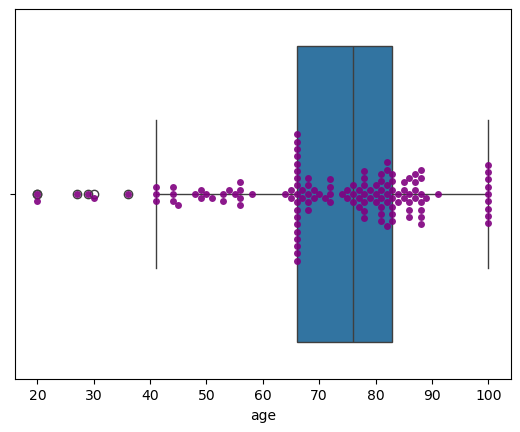

In [21]:
sns.boxplot(x=df["age"])
sns.swarmplot(x=df["age"], color="purple", alpha=0.9)
plt.show()

In [22]:
# IQR method for detecting outliers in age
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
age_outliers = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

# Show number of outliers and examples
print(f"Number of age outliers: {len(age_outliers)}")
age_outliers[['subject_id', 'age']].head()


Number of age outliers: 6


,subject_id,age
1,10011,36
25,10067,29
34,10090,30
38,10098,20
50,10120,27


This is an exception according to statistics, but we will leave the data because we know the reality and that is okay.

#### Outliers Detection - Potassium level

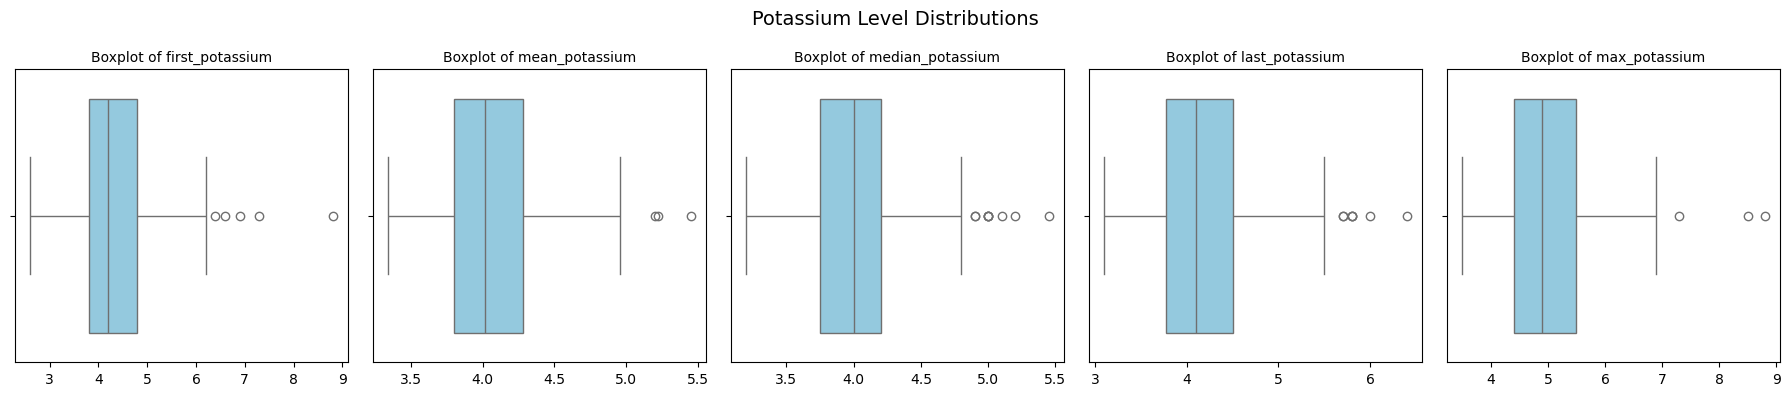

In [23]:
# Define all potassium features
columns = ["first_potassium", "mean_potassium", "median_potassium", "last_potassium", "max_potassium"]
fig, axes = plt.subplots(1, 5, figsize=(18, 4))  
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot of {col}", fontsize=10)
    axes[i].set_xlabel('')

plt.suptitle("Potassium Level Distributions", fontsize=14)
plt.tight_layout()
plt.show()


We will check for exceptions in the parameters that interest us.

In [24]:
# Initialize rubric for any outlier
any_outlier = pd.Series(False, index=df.index)

# Columns to check for outliers
numeric_cols = ['last_potassium', 'max_potassium']

# Create column to store which feature was outlier
outlier_details = pd.Series('', index=df.index)

# Detect outliers and track the parameter
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = (df[col] < lower) | (df[col] > upper)
    any_outlier |= outliers
    outlier_details[outliers] += f"{col} "

# Create table of outliers and their reason
outlier_rows = df[any_outlier].copy()
outlier_rows['Outlier_Feature'] = outlier_details[any_outlier].str.strip()

# Print results
print(f"Total outlier rows found: {outlier_rows.shape[0]}")
display(outlier_rows[['subject_id', 'Outlier_Feature', 'died_during_icu']])

# Remove only survivors with outlier values
should_remove = any_outlier & (df['died_during_icu'] == 0)

# Count how many are being removed
removed_count = should_remove.sum()
print(f"\nRemoved {removed_count} outlier rows (survivors only).")

# Apply removal
df = df[~should_remove].copy()


Total outlier rows found: 10


,subject_id,Outlier_Feature,died_during_icu
28,10076,last_potassium,1
35,10093,last_potassium,1
40,10102,max_potassium,1
50,10120,last_potassium,1
55,10126,max_potassium,1
61,40177,last_potassium,0
62,40177,last_potassium,1
71,40503,last_potassium,1
94,41976,max_potassium,0
96,42033,last_potassium,0



Removed 3 outlier rows (survivors only).


Because the others are all dead, we will not remove them from the data. We want the model to learn them because they are dead and have great significance for the machine learning model.

## Initial features distributions:

### Genaral distribution:

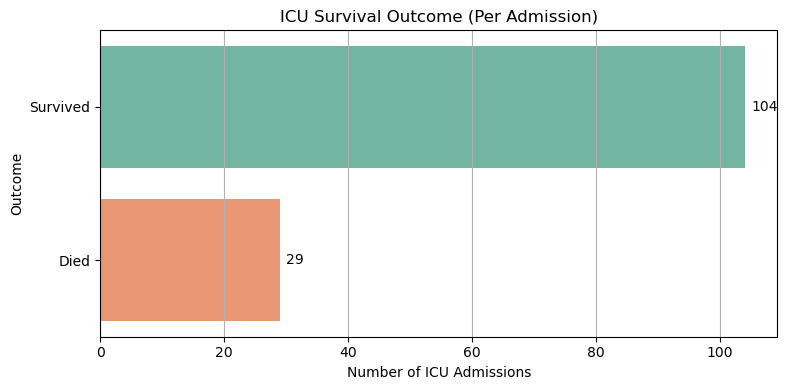

In [25]:
# Map outcome labels
outcome_map = {
    0: 'Survived',
    1: 'Died'
}

outcome_counts = df['died_during_icu'].map(outcome_map).value_counts().reset_index()
outcome_counts.columns = ['Outcome', 'Count']
plt.figure(figsize=(8, 4))
sns.barplot(data=outcome_counts, y='Outcome', x='Count', palette='Set2')

# Add count labels
for index, row in outcome_counts.iterrows():
    plt.text(row['Count'] + 1, index, f"{row['Count']}", va='center')

plt.title('ICU Survival Outcome (Per Admission)')
plt.xlabel('Number of ICU Admissions')
plt.ylabel('Outcome')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Gender distribution:

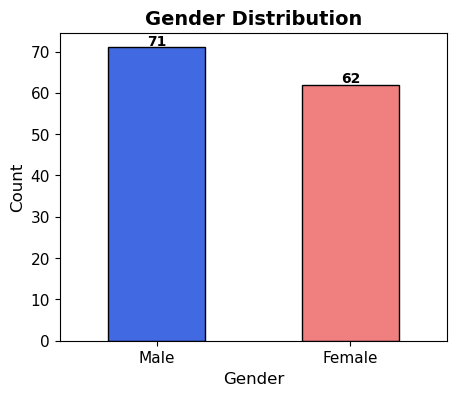

In [26]:
# Plot gender distribution
plt.figure(figsize=(5, 4))
df['gender'].value_counts().plot(kind='bar', color=['royalblue', 'lightcoral'], edgecolor='black')
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Gender Distribution", fontsize=14, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'], rotation=0, fontsize=11)
plt.yticks(fontsize=11)
# Display values on top of bars
for i, count in enumerate(df['gender'].value_counts()):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10, fontweight='bold')
plt.show()

### Age distribution:

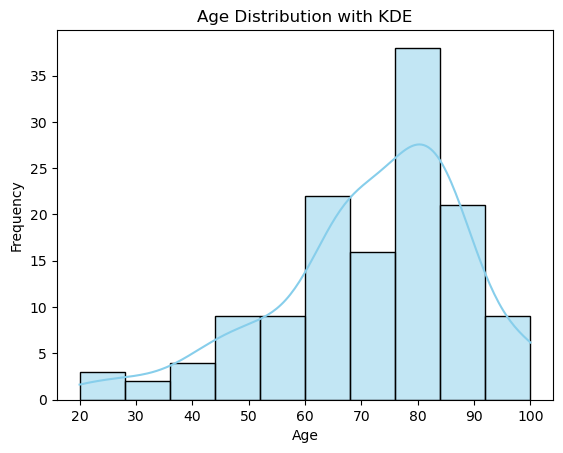

In [27]:
sns.histplot(df["age"], kde=True, bins=10, color="skyblue")
plt.title("Age Distribution with KDE")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

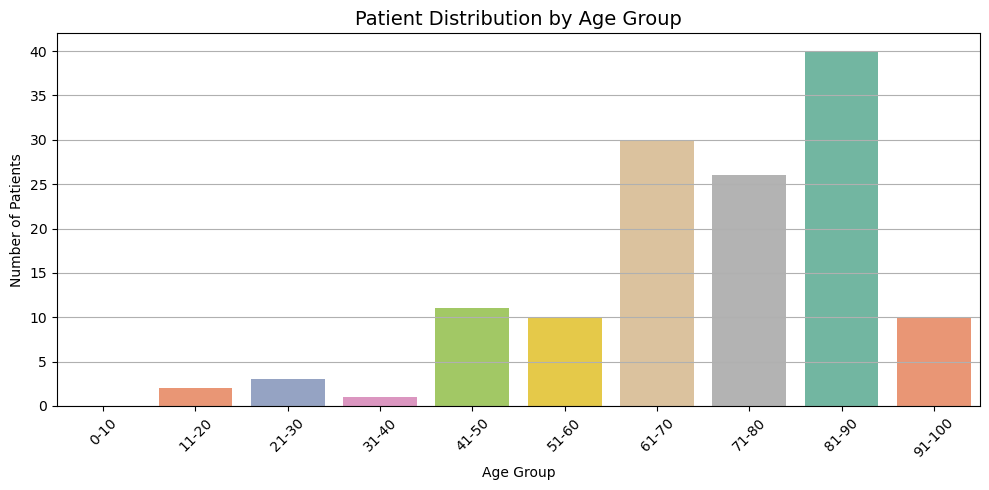

In [28]:
# Plot distribution of patients by existing 'age_group'
age_counts = df['age_group'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=age_counts.index.astype(str), y=age_counts.values, palette='Set2')
plt.title('Patient Distribution by Age Group', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Ethnicity distribution:

In [29]:
df.ethnicity.value_counts()

ethnicity
WHITE                                                       90
HISPANIC/LATINO - PUERTO RICAN                              14
UNKNOWN/NOT SPECIFIED                                       11
BLACK/AFRICAN AMERICAN                                       7
OTHER                                                        3
HISPANIC OR LATINO                                           3
ASIAN                                                        2
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
UNABLE TO OBTAIN                                             1
Name: count, dtype: int64

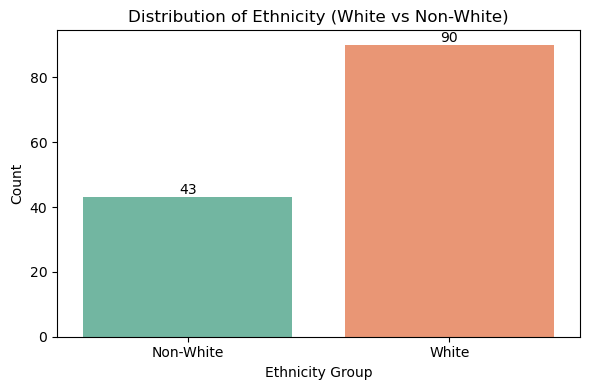

In [30]:

df['ethnicity_group'] = df['ethnicity'].apply(lambda x: 'White' if 'WHITE' in str(x).upper() else 'Non-White')

# Plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x="ethnicity_group", palette="Set2")
plt.title("Distribution of Ethnicity (White vs Non-White)")
plt.xlabel("Ethnicity Group")
plt.ylabel("Count")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### Potassium levels distributions:

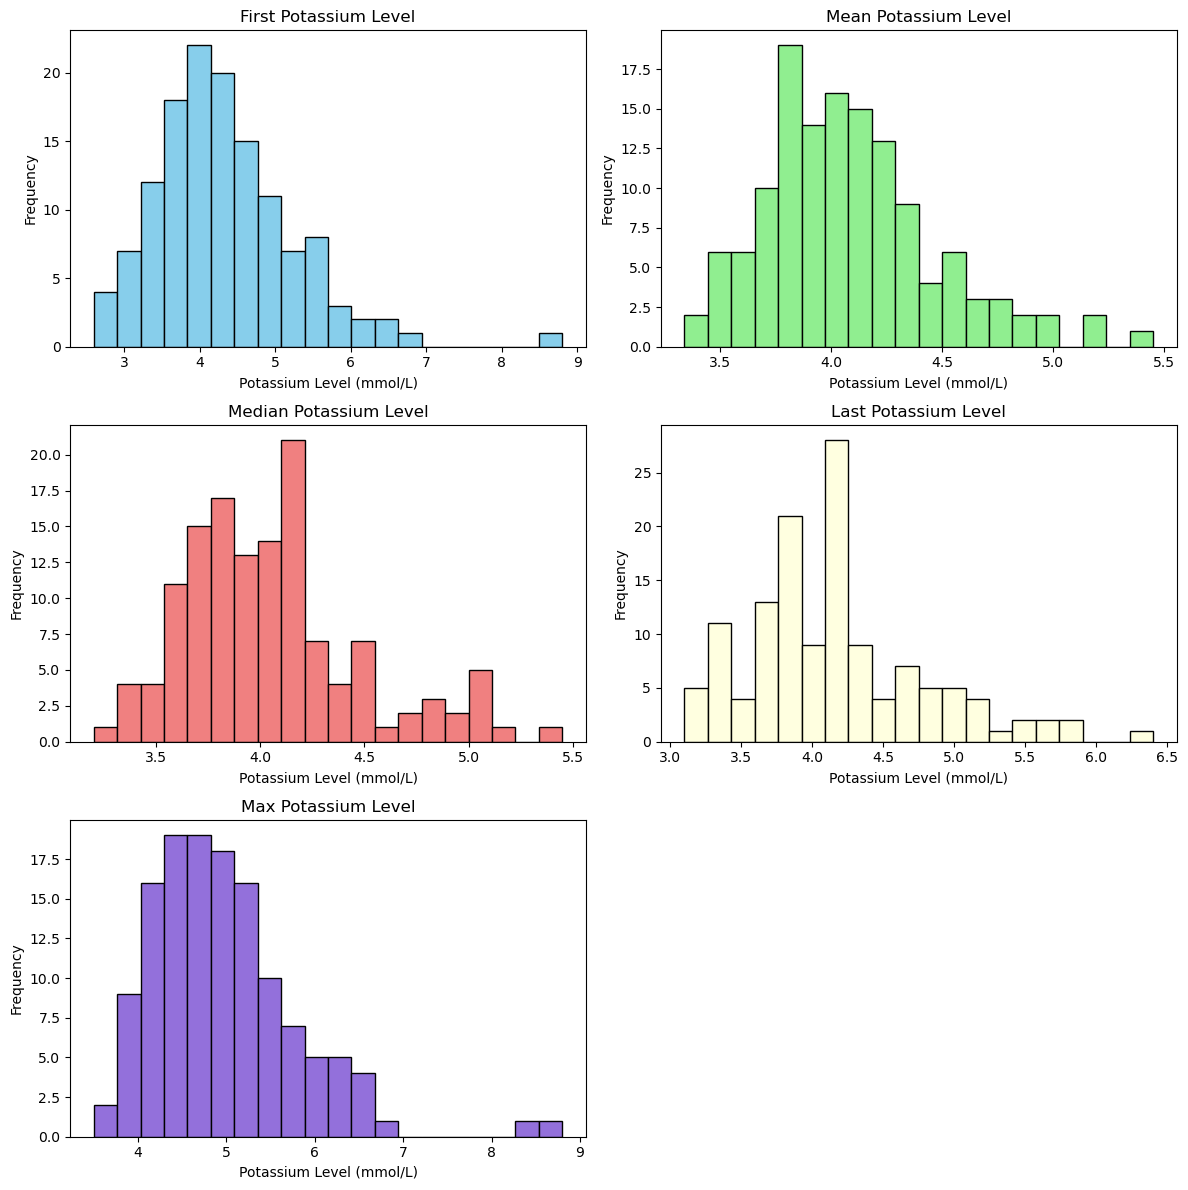

In [31]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# First
axes[0, 0].hist(df['first_potassium'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('First Potassium Level')
axes[0, 0].set_xlabel('Potassium Level (mmol/L)')
axes[0, 0].set_ylabel('Frequency')

# Mean
axes[0, 1].hist(df['mean_potassium'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Mean Potassium Level')
axes[0, 1].set_xlabel('Potassium Level (mmol/L)')
axes[0, 1].set_ylabel('Frequency')

# Median
axes[1, 0].hist(df['median_potassium'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Median Potassium Level')
axes[1, 0].set_xlabel('Potassium Level (mmol/L)')
axes[1, 0].set_ylabel('Frequency')

# Last
axes[1, 1].hist(df['last_potassium'], bins=20, color='lightyellow', edgecolor='black')
axes[1, 1].set_title('Last Potassium Level')
axes[1, 1].set_xlabel('Potassium Level (mmol/L)')
axes[1, 1].set_ylabel('Frequency')

# Max
axes[2, 0].hist(df['max_potassium'], bins=20, color='mediumpurple', edgecolor='black')
axes[2, 0].set_title('Max Potassium Level')
axes[2, 0].set_xlabel('Potassium Level (mmol/L)')
axes[2, 0].set_ylabel('Frequency')

# Hide the last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


* The type of distribution (normal/non-normal) will be examined later as part of statistical tests.

### COPD cases distribution:

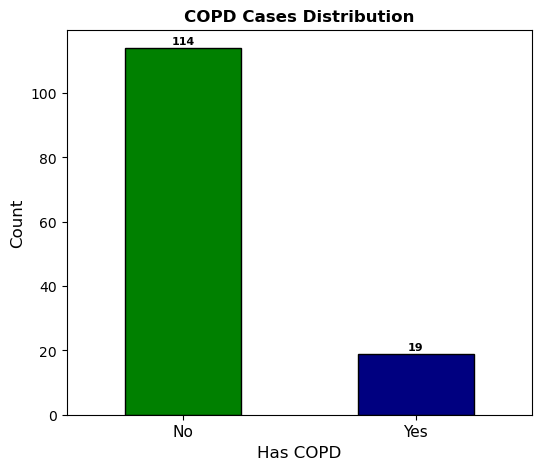

In [32]:
# Plot COPD distribution
plt.figure(figsize=(6, 5))
df['has_COPD'].value_counts().plot(kind='bar', color=['green', 'navy'], edgecolor='black')
plt.xlabel("Has COPD", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("COPD Cases Distribution", fontsize=12, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0, fontsize=11)
plt.yticks(fontsize=10)
# Display values on top of bars
for i, count in enumerate(df['has_COPD'].value_counts()):
    plt.text(i, count + 1, str(count), ha='center', fontsize=8, fontweight='bold')
plt.show()

### Target variable - death during ICU distribution:

died_during_icu
0    104
1     29
Name: count, dtype: int64 



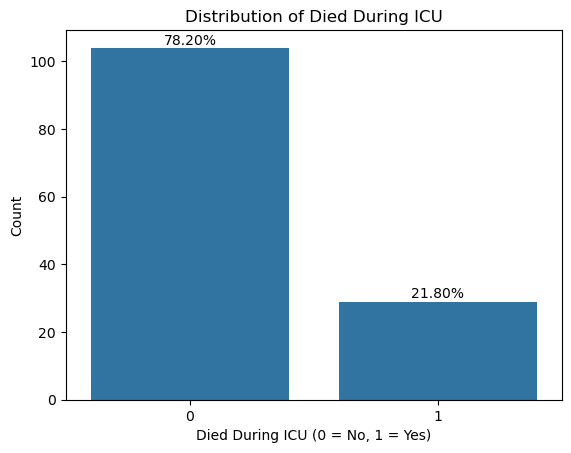

In [33]:
print(df.died_during_icu.value_counts(), "\n")

# Count the number of each class
class_counts = df['died_during_icu'].value_counts()
sns.countplot(x='died_during_icu', data=df)
total = len(df)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height + 1, f'{height / total * 100:.2f}%', ha='center')
plt.title('Distribution of Died During ICU')
plt.xlabel('Died During ICU (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

---
---
---

# Relationship Analysis

In [34]:
df.shape

(133, 15)

In [35]:
df.head()

,subject_id,hadm_id,icustay_id,gender,age,age_group,ethnicity,died_during_icu,first_potassium,mean_potassium,median_potassium,last_potassium,max_potassium,has_COPD,ethnicity_group
0,10006,142345,206504,F,71,71-80,BLACK/AFRICAN AMERICAN,0,6.0,4.575000,4.50,3.9,6.0,0,Non-White
1,10011,105331,232110,F,36,31-40,UNKNOWN/NOT SPECIFIED,1,5.9,3.986364,3.85,4.6,5.9,0,Non-White
2,10013,165520,264446,F,87,81-90,UNKNOWN/NOT SPECIFIED,1,4.2,4.150000,4.15,4.1,4.2,0,Non-White
3,10017,199207,204881,F,77,71-80,WHITE,0,4.7,3.700000,3.75,3.9,4.7,1,White
4,10019,177759,228977,M,48,41-50,WHITE,1,3.3,4.400000,3.60,5.2,6.3,0,White


---

## Ethnicity Group vs. ICU death

We tested whether ethnicity (White vs Non-White) is associated with ICU survival using a Chi-Square test.

In [36]:
contingency_table = pd.crosstab(df['ethnicity_group'], df['died_during_icu'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi_square_results = pd.DataFrame({
    'Statistic': [chi2],
    'Degrees of Freedom': [dof],
    'P-value': [p]
})

chi_square_results


,Statistic,Degrees of Freedom,P-value
0,0.003102,1,0.955582




The Chi-Square test result suggests that the proportion of survival
and death was nearly identical between White and Non-White groups, indicating
no meaningful difference beyond what would be expected by chance.

---

## Age vs. ICU death

First, we used the Shapiro-Wilk test to assess whether the age data in each group followed a normal distribution.

In [37]:
from scipy.stats import shapiro

shapiro_survived = shapiro(df[df['died_during_icu'] == 0]['age'])
shapiro_died = shapiro(df[df['died_during_icu'] == 1]['age'])

shapiro_results = pd.DataFrame({
    'Group': ['Survived', 'Died'],
    'Shapiro Statistic': [shapiro_survived.statistic, shapiro_died.statistic],
    'P-Value': [shapiro_survived.pvalue, shapiro_died.pvalue]
})

shapiro_results

,Group,Shapiro Statistic,P-Value
0,Survived,0.957917,0.002244
1,Died,0.894438,0.007228


Since the Shapiro-Wilk test returned a p-value of 0.0072, we reject the null hypothesis of normality. The age distribution in this group is not normal.



Therefore, due to the non-normal distribution of age, we used the non-parametric Mann-Whitney U test to compare the age between the two outcome groups

In [38]:
from scipy.stats import mannwhitneyu
survived = df[df['died_during_icu'] == 0]['age']
died = df[df['died_during_icu'] == 1]['age']
stat, p_value = mannwhitneyu(survived, died, alternative='two-sided')
mannwhitney_results = pd.DataFrame({
    'Test': ['Mann-Whitney U'],
    'U Statistic': [stat],
    'P-Value': [p_value]
})

mannwhitney_results



,Test,U Statistic,P-Value
0,Mann-Whitney U,1520.5,0.947779


No statistically significant difference in age was found between patients who survived and those who died during ICU stay (Mann-Whitney U test, p = 0.9173).

In [39]:
# Convert 'age_group' to a numeric start value for correlation
def get_age_start(val):
    try:
        return int(str(val).split('-')[0])
    except:
        return None

df['age_group_numeric'] = df['age_group'].apply(get_age_start)

# Calculate correlation
correlation = df[['age_group_numeric', 'died_during_icu']].corr().iloc[0,1]
print(f"Correlation between age group and ICU mortality: {correlation:.3f}")

Correlation between age group and ICU mortality: -0.130


As we expected and saw with age without the groups - there is no correlation between survival and age groups

---

## Gender vs. ICU death

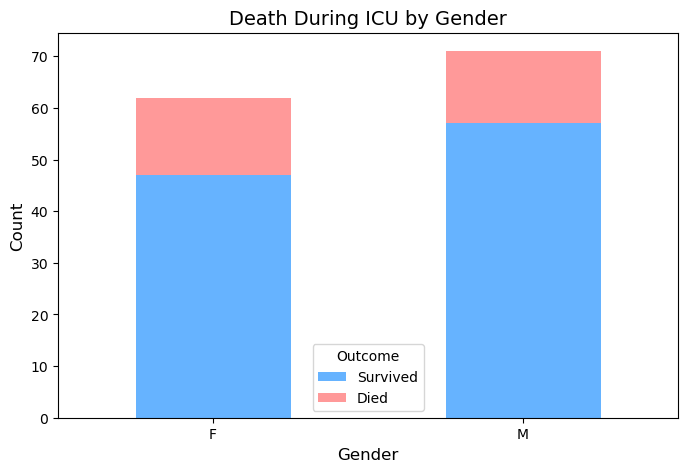

died_during_icu,0,1
gender,,
F,47,15
M,57,14


In [40]:
gender_death = df.groupby(['gender', 'died_during_icu']).size().unstack()

gender_death.plot(kind='bar', stacked=True, figsize=(8, 5), color=['#66b3ff', '#ff9999'])
plt.title('Death During ICU by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(['Survived', 'Died'], title='Outcome')
plt.show()
gender_death

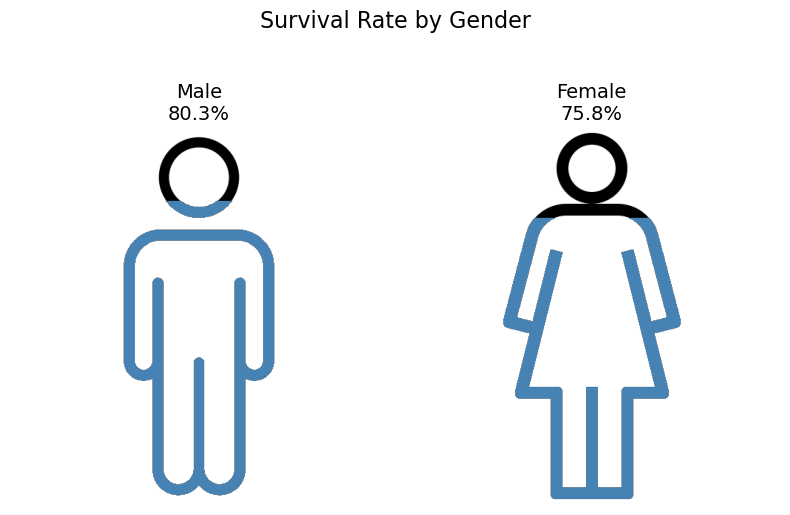

In [41]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# Extract survival rate per gender from gender_death table
gender_survival = (gender_death[0] / gender_death.sum(axis=1)).to_dict()

icon_paths = {
    'M': 'man.png',
    'F': 'woman.png'
}

# Plot
fill_color = (70, 130, 180, 255)  # steelblue
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

for i, gender in enumerate(['M', 'F']):
    ax = axs[i]
    img = Image.open(icon_paths[gender]).convert("RGBA")
    img_array = np.array(img)

    colored_img = img_array.copy()
    height = img_array.shape[0]
    cutoff = int(height * (1 - gender_survival[gender]))
    mask = img_array[..., 3] > 0  # where image is not transparent

    for y in range(cutoff, height):
        for x in range(img_array.shape[1]):
            if mask[y, x]:
                colored_img[y, x] = fill_color

    ax.imshow(colored_img)
    ax.axis('off')
    ax.set_title(f"{'Male' if gender == 'M' else 'Female'}\n{gender_survival[gender]*100:.1f}%", fontsize=14)

plt.suptitle("Survival Rate by Gender", fontsize=16)
plt.tight_layout()
plt.show()


#### Statistic test - Chi square for group comparison:

In [42]:
chi2, p_value, dof, expected = stats.chi2_contingency(gender_death)

print(f"Chi-square statistic: {chi2}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant relationship between gender and survival outcome.")
else:
    print("There is no significant relationship between gender and survival outcome.")

Chi-square statistic: 0.17060481686645956
Degrees of freedom: 1
P-value: 0.6795748462895563
There is no significant relationship between gender and survival outcome.


**we fail to reject the null hypothesis, meaning patient gender does not significantly affect the death outcome.**

<Figure size 1000x600 with 0 Axes>

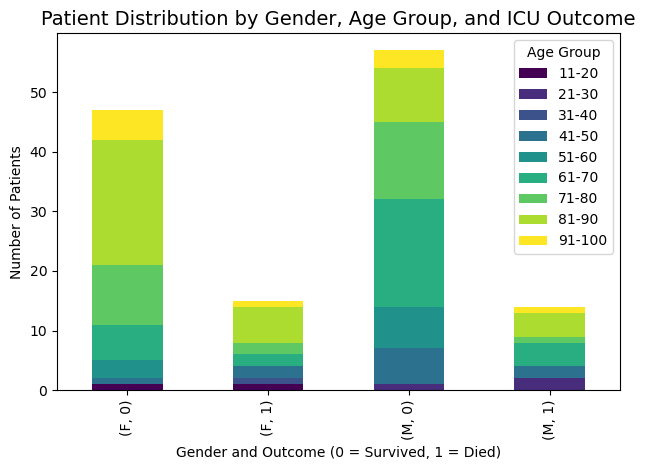

In [43]:
gender_age = pd.crosstab([df['gender'], df['died_during_icu']], df['age_group'])
plt.figure(figsize=(10, 6))
gender_age.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Patient Distribution by Gender, Age Group, and ICU Outcome', fontsize=14)
plt.xlabel('Gender and Outcome (0 = Survived, 1 = Died)')
plt.ylabel('Number of Patients')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()


---

## COPD Status:

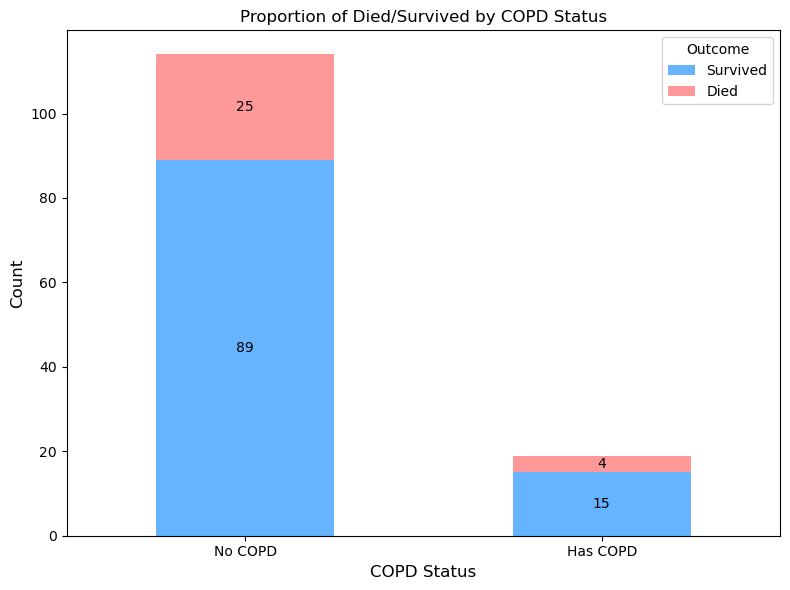

In [44]:
proportions_copd = df.groupby('has_COPD')['died_during_icu'].value_counts().unstack()
ax = proportions_copd.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#66b3ff', '#ff9999'])

plt.title('Proportion of Died/Survived by COPD Status', fontsize=12)
plt.xlabel('COPD Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No COPD', 'Has COPD'], rotation=0)
plt.legend(['Survived', 'Died'], title='Outcome')

# Add text labels
for i, (index, row) in enumerate(proportions_copd.iterrows()):
    bottom = 0
    for outcome, value in row.items():
        ax.text(i, bottom + value / 2, f'{int(value)}', ha='center', va='center', fontsize=10)
        bottom += value

plt.tight_layout()
plt.show()


#### Statistic test (Z) - proportion of death rgarding COPD cases:

In [45]:
# Count the deaths and survivors for both groups
death_copd = df[df['has_COPD'] == 1]['died_during_icu'].sum()
total_copd = len(df[df['has_COPD'] == 1])

death_no_copd = df[df['has_COPD'] == 0]['died_during_icu'].sum()
total_no_copd = len(df[df['has_COPD'] == 0])

p1 = death_copd / total_copd  # Proportion of deaths in COPD group
p2 = death_no_copd / total_no_copd  # Proportion of deaths in non-COPD group

p_combined = (death_copd + death_no_copd) / (total_copd + total_no_copd) # Combined proportion
se = np.sqrt(p_combined * (1 - p_combined) * (1 / total_copd + 1 / total_no_copd)) # Standard error for the difference in proportions
z = (p1 - p2) / se # Z-test statistic
p_value = 2 * (1 - stats.norm.cdf(abs(z))) # Calculate p-value (two-tailed test)

print(f"Z-statistic: {z}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("There is a statistically significant difference in death outcomes based on COPD status (Reject the null hypothesis).")
else:
    print("There is no statistically significant difference in death outcomes based on COPD status (Fail to reject the null hypothesis).")


Z-statistic: -0.08573033616722678
P-value: 0.9316807861246019
There is no statistically significant difference in death outcomes based on COPD status (Fail to reject the null hypothesis).


**we fail to reject the null hypothesis, meaning COPD status does not significantly affect the death outcome.**

Fisher’s Exact Test: COPD Status vs. ICU Mortality
We used Fisher’s Exact Test because the COPD group is relatively small (only 4 deaths),
which may violate the assumptions of other tests like the Chi-Square or Z-test.
This test is more accurate for small sample sizes.

In [46]:
contingency_table = [[89, 25],   # No COPD
                     [15, 4]]    # Has COPD
odds_ratio, p_value = fisher_exact(contingency_table)

print(f"Odds Ratio: {odds_ratio:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("\n✅ Statistically significant association found between COPD and ICU mortality.")
else:
    print("\n❌ No statistically significant association found between COPD and ICU mortality.")


Odds Ratio: 0.949
P-value: 1.0000

❌ No statistically significant association found between COPD and ICU mortality.


---

## Potassium Level:



Normal potassium levels in the human body typically range from **3.5 to 5.0 mmol/L**.  
Levels outside this range can lead to serious cardiac and neuromuscular complications.

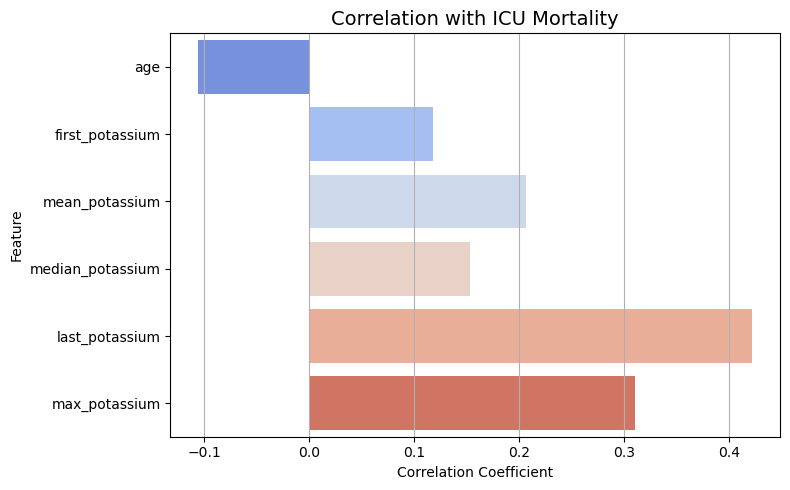

In [47]:
# Define numerical columns (excluding 'died_during_icu' from the correlation itself)
features = ['age', 'first_potassium', 'mean_potassium', 'median_potassium', 'last_potassium', 'max_potassium']

# Calculate correlations of each feature with died_during_icu
correlations = df[features + ['died_during_icu']].corr()['died_during_icu'].drop('died_during_icu')

# Plot the correlation as a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlation with ICU Mortality', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


The correlation matrix shows a moderate positive correlation between last_potassium and died_during_icu (r = 0.42), suggesting that higher last potassium levels may be associated with increased ICU mortality.
Additionally, max_potassium also has a positive correlation with ICU death (r = 0.31), supporting its potential importance as a risk indicator.

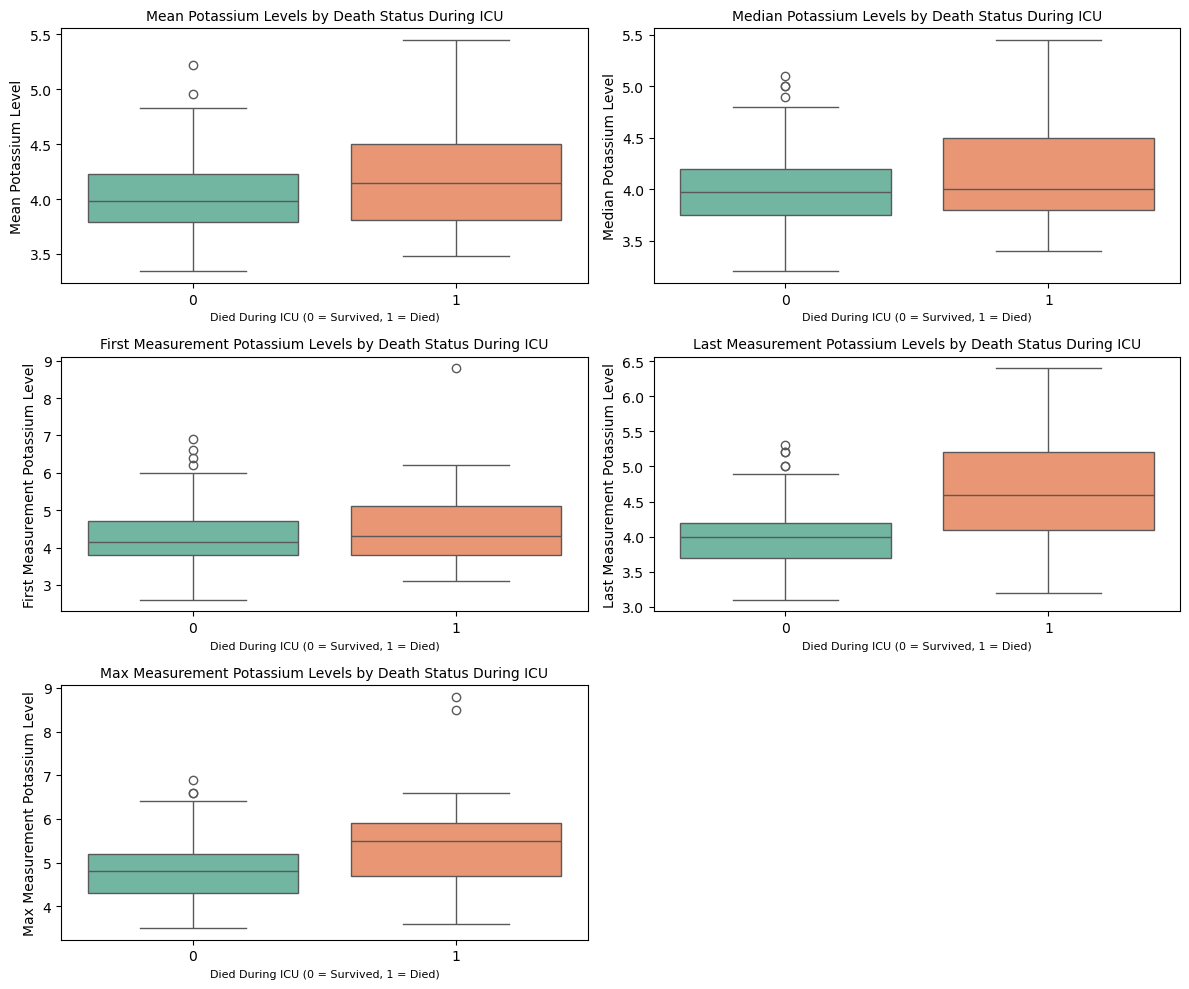

In [48]:
plt.figure(figsize=(12, 10))

potassium_features = ['mean_potassium', 'median_potassium', 'first_potassium', 'last_potassium', 'max_potassium']
titles = ['Mean', 'Median', 'First Measurement', 'Last Measurement', 'Max Measurement']

for i, feature in enumerate(potassium_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='died_during_icu', y=feature, data=df, palette='Set2')
    plt.title(f'{titles[i-1]} Potassium Levels by Death Status During ICU', fontsize=10)
    plt.xlabel('Died During ICU (0 = Survived, 1 = Died)', fontsize=8)
    plt.ylabel(f'{titles[i-1]} Potassium Level')

plt.tight_layout()
plt.show()


We applied both the Welch’s T-test and the Mann-Whitney U test to ensure the robustness of our results. The consistency between the tests strengthens our confidence in the findings, especially given the non-normal distribution of several potassium measures.



In [49]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, levene
import pandas as pd

potassium_features = ['mean_potassium', 'median_potassium', 'first_potassium', 'last_potassium', 'max_potassium']
results = {}

for feature in potassium_features: 
    survived = df[df['died_during_icu'] == 0][feature].dropna()
    died = df[df['died_during_icu'] == 1][feature].dropna()
    
    # Normality tests
    p_normal_survived = shapiro(survived).pvalue
    p_normal_died = shapiro(died).pvalue
    normal = (p_normal_survived > 0.05) and (p_normal_died > 0.05)

    # Levene test for equal variances
    p_levene = levene(survived, died).pvalue if normal else None
    equal_var = p_levene > 0.05 if p_levene is not None else None

    # T-test (only if both groups are normal)
    if normal:
        t_stat, t_p = ttest_ind(survived, died, equal_var=equal_var)
        t_type = 'Student' if equal_var else 'Welch'
        u_stat, u_p = None, None
    else:
        t_stat, t_p, t_type = None, None, 'Skipped (non-normal)'
        u_stat, u_p = mannwhitneyu(survived, died, alternative='two-sided')

    # Save results
    results[feature] = {
        'Shapiro p (Survived)': round(p_normal_survived, 5),
        'Shapiro p (Died)': round(p_normal_died, 5),
        'Normality OK': normal,
        'Levene p': round(p_levene, 5) if p_levene is not None else None,
        'T-test type': t_type,
        'T-test p': round(t_p, 5) if t_p is not None else None,
        'Mann-Whitney p': round(u_p, 5) if u_p is not None else None
    }

# Display final results
results_df = pd.DataFrame(results).T
display(results_df)


,Shapiro p (Survived),Shapiro p (Died),Normality OK,Levene p,T-test type,T-test p,Mann-Whitney p
mean_potassium,0.01455,0.21826,False,None,Skipped (non-normal),None,0.07043
median_potassium,0.0011,0.0486,False,None,Skipped (non-normal),None,0.33938
first_potassium,0.00647,0.00126,False,None,Skipped (non-normal),None,0.30901
last_potassium,0.03844,0.52706,False,None,Skipped (non-normal),None,0.00016
max_potassium,0.00141,0.03749,False,None,Skipped (non-normal),None,0.0037


- For **mean, median**, and **first** potassium levels, the p-values from the tests indicate **no significant differences** between those who survived and those who died. These measurements do not seem to be strongly associated with death status during ICU.

- For the **last potassium measurement & Max potassium**, the Welch's Mann-Whitney shows a **significant difference**, suggesting that **the last potassium measurement & Max potassium are linked to survival in the ICU.**

<Figure size 2000x1500 with 0 Axes>

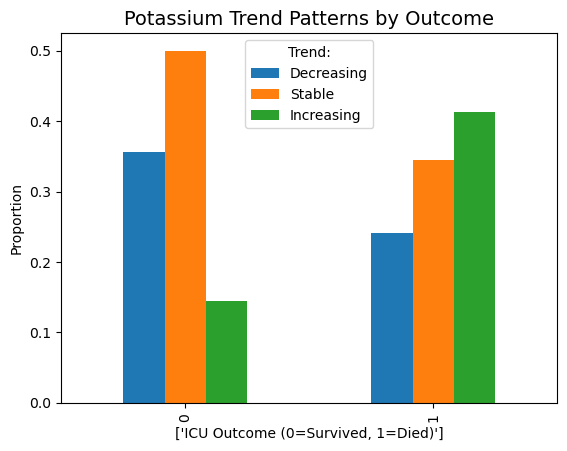

In [50]:
# Potassium Trend Patterns - first vs. last measurements
ndf = pd.DataFrame()
plt.figure(figsize=(20, 15))
ndf['k_trend'] = df['last_potassium'] - df['first_potassium']
ndf['k_trend_category'] = pd.cut(ndf['k_trend'], 
                                    bins=[-float('inf'), -0.5, 0.5, float('inf')],
                                    labels=['Decreasing', 'Stable', 'Increasing'])
outcome_trend = pd.crosstab(df['died_during_icu'], ndf['k_trend_category'], normalize='index') # normalize to create proportion
outcome_trend.plot(kind='bar')
plt.title('Potassium Trend Patterns by Outcome', fontsize=14)
plt.xlabel(['ICU Outcome (0=Survived, 1=Died)'])
plt.ylabel('Proportion')
plt.legend(title='Trend:')
plt.show();

In [51]:
chi_results = {}
# Loop over each potassium trend category
for trend in ndf['k_trend_category'].unique():
    selected = (ndf['k_trend_category'] == trend)
    other = ~selected

    # Create 2x2 contingency table: rows = trend vs not trend, columns = survived/died
    survived_trend = ((df['died_during_icu'] == 0) & selected).sum()
    died_trend = ((df['died_during_icu'] == 1) & selected).sum()
    survived_other = ((df['died_during_icu'] == 0) & other).sum()
    died_other = ((df['died_during_icu'] == 1) & other).sum()

    table = [[survived_trend, died_trend],
             [survived_other, died_other]]

    chi2, p, dof, expected = chi2_contingency(table)

    # Save results
    chi_results[trend] = {
        'Survived (Trend)': survived_trend,
        'Died (Trend)': died_trend,
        'Survived (Other)': survived_other,
        'Died (Other)': died_other,
        'P-value': round(p, 4)
    }

# Display results
chi_df = pd.DataFrame(chi_results).T
display(chi_df)

# Summary printout
for trend, row in chi_df.iterrows():
    sig = 'Significant' if row['P-value'] < 0.05 else 'Not Significant'
    print(f"{trend}: p = {row['P-value']} → {sig}")


,Survived (Trend),Died (Trend),Survived (Other),Died (Other),P-value
Decreasing,37.0,7.0,67.0,22.0,0.3500
Stable,52.0,10.0,52.0,19.0,0.2038
Increasing,15.0,12.0,89.0,17.0,0.0034


Decreasing: p = 0.35 → Not Significant
Stable: p = 0.2038 → Not Significant
Increasing: p = 0.0034 → Significant


Based on the Chi-Square test results, only the Increasing potassium trend showed a statistically significant association with ICU mortality, indicating that patients with rising potassium levels were more likely to die. The Stable and Decreasing trends did not demonstrate a significant relationship with survival outcome.






---

## Summary 

### What variables were found to be significant predictors of mortality? 

Several variables were found to be significantly associated with ICU mortality:

1. Potassium Trend (Increasing) – Patients whose potassium levels increased during their ICU stay had significantly higher mortality rates.
This was confirmed by both Fisher’s Exact Test and Chi-Square Test (p < 0.05).

2. Last Potassium Level – Showed a moderate positive correlation with ICU death (r ≈ 0.42), and the difference between survivors and non-survivors was statistically significant.

3. Max Potassium Level – Also positively correlated with death (r ≈ 0.31), and showed significant group differences in non-parametric tests.

### Are there any unusual data that may affect the results of the study? 

Yes. One important issue is that some patients appear multiple times in the dataset (i.e., they were admitted more than once). Since many of their physiological values remain similar across admissions, this repetition can introduce data duplication bias, especially in models that assume independent observations.

In addition, as shown in the exploratory analysis, there are several extreme values in potassium measurements (e.g., unusually high max or last potassium levels). These outliers were handled by removing only survivors with extreme values to minimize distortion of mortality comparisons.




### What other actions can be performed to improve the surgery or to test additional hypotheses? 

Adding more clinical variables (e.g., additional lab tests or vital signs) could help uncover deeper associations and improve the overall analysis. Moreover, some subgroups in the data were very small, making it difficult to draw statistically meaningful conclusions — increasing the dataset, especially for underrepresented groups, would greatly enhance result validity.









## Thank you ! :)